# Chapter: Input-Output Modeling - Part 2: 


## Topic: Distillation column modeling using ARMAX

In [1]:
# import packages 
import matplotlib.pyplot as plt, numpy as np, control
from sklearn.preprocessing import StandardScaler
from sippy import system_identification as SysID
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import ccf
from matplotlib.ticker import MaxNLocator

# package settings
plt.rcParams.update({'font.size': 14})
assert(control.__version__ < '0.9'), "To avoid errors, downgrade the control package to a version < 0.9.0. See https://github.com/CPCLAB-UNIPI/SIPPY/issues/48 for details."

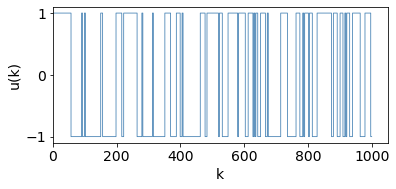

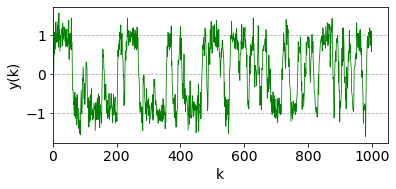

In [2]:
# read data and plot
data = np.loadtxt('DistillationColumn_SNR10.csv', delimiter=',')
u = data[:,0, None]; y = data[:,1, None]

# plots
plt.figure(figsize=(6,2.5))
plt.plot(u, 'steelblue', linewidth=0.8, drawstyle='steps')
plt.ylabel('u(k)'), plt.xlabel('k'), plt.xlim(0)

plt.figure(figsize=(6,2.5))
plt.plot(y, 'g', linewidth=0.8)
plt.ylabel('y(k)'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

In [3]:
# center data before model fitting
u_scaler = StandardScaler(with_std=False); u_centered = u_scaler.fit_transform(u) 
y_scaler = StandardScaler(with_std=False); y_centered = y_scaler.fit_transform(y) 

In [4]:
# fit FIR model
FIRmodel = SysID(y_centered, u_centered, 'FIR', IC='AIC', nb_ord=[1,20], delays=[0,5]) # a range of 1 to 20 is specified for optimal order search 
print(FIRmodel.G)

suggested orders are: Na= 0 ; Nb= 11 Delay:  1

0.08988 z^10 + 0.2269 z^9 + 0.179 z^8 + 0.1011 z^7 + 0.1283 z^6 + 0.06162 z^5 + 0.033 z^4 + 0.05666 z^3 + 0.003081 z^2 + 0.01265 z + 0.04627
--------------------------------------------------------------------------------------------------------------------------------------------
                                                                    z^12

dt = 1.0



In [5]:
# fit ARX model
ARXmodel = SysID(y_centered, u_centered, 'ARX', IC='AIC', na_ord=[1,10], nb_ord=[1,10], delays=[0,2])
print(ARXmodel.G)

suggested orders are: Na= 5 ; Nb= 5 Delay:  1

      0.09337 z^4 + 0.2207 z^3 + 0.1582 z^2 + 0.08027 z + 0.1065
----------------------------------------------------------------------
z^6 - 0.04928 z^5 - 0.0614 z^4 - 0.04642 z^3 - 0.06834 z^2 - 0.07631 z

dt = 1.0



In [6]:
# fit ARMAX model
ARMAXmodel = SysID(y_centered, u_centered, 'ARMAX', IC='AIC', na_ord=[1,10], nb_ord=[1,10], nc_ord=[1,10], delays=[0,2], max_iterations=1000)

Armax model:
- Params:
  na: 2 (1, 10)
  nb: 3 (1, 10)
  nc: 2 (1, 10)
  delay: 0 (0, 2)
  dt: 1.0 
  method: AIC 
  max iterations: 1000 
- Output:
  G: 
0.004363 z^2 + 0.08964 z + 0.1343
---------------------------------
   z^3 - 0.8731 z^2 + 0.1135 z

dt = 1.0
 
  H: 
z^3 - 0.8432 z^2 + 0.1254 z
---------------------------
z^3 - 0.8731 z^2 + 0.1135 z

dt = 1.0
 
  Vn: 0.08602792168478784 
  Model Output: [[-1.44477887e-01  4.99163600e-04 -5.46967443e-02  1.80910724e-01
   3.91212630e-01  5.62478936e-01  6.82556341e-01  7.73228423e-01
   8.22151231e-01  8.81579659e-01  9.12195543e-01  9.21358901e-01
   9.27973091e-01  9.36433675e-01  9.65780492e-01  9.63213953e-01
   9.76015793e-01  9.74285088e-01  9.79209455e-01  9.56378200e-01
   9.66224484e-01  9.74621366e-01  9.82567841e-01  9.68830132e-01
   9.46409356e-01  9.56061372e-01  9.45615030e-01  9.40349598e-01
   9.53063717e-01  9.75806252e-01  9.64699073e-01  9.58418945e-01
   9.56868703e-01  9.64434910e-01  9.66480886e-01  9.59391266

In [7]:
#%% %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                         Residual analysis
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

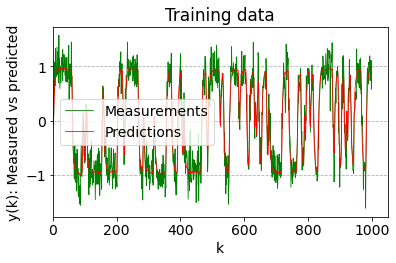

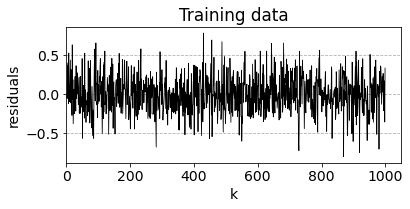

In [8]:
# get model predictions and residuals on training dataset
y_predicted_centered =ARMAXmodel.Yid
y_predicted = np.transpose(y_scaler.inverse_transform(y_predicted_centered))
residuals = y - y_predicted

plt.figure(figsize=(6,3.5)), plt.plot(y, 'g', linewidth=0.8, label='Measurements'), plt.plot(y_predicted, 'r', linewidth=0.8, label='Predictions')
plt.title('Training data'), plt.ylabel('y(k): Measured vs predicted'), plt.xlabel('k'), plt.legend(), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(6,2.5)), plt.plot(residuals, 'black', linewidth=0.8)
plt.title('Training data'), plt.ylabel('residuals'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

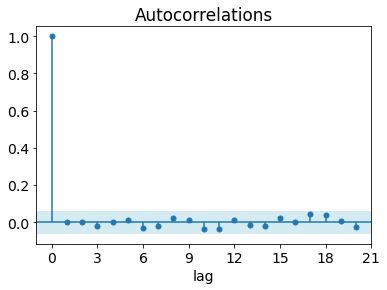

In [13]:
# ACF of residuals
conf_int = 1.96/np.sqrt(len(residuals))

plot_acf(residuals, lags= 20, alpha=None, title='')
plt.gca().axhspan(-conf_int, conf_int, facecolor='lightblue', alpha=0.5) # shaded confidence interval
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # integer xtick labels
plt.xlabel('lag'), plt.title('Autocorrelations')
plt.show()

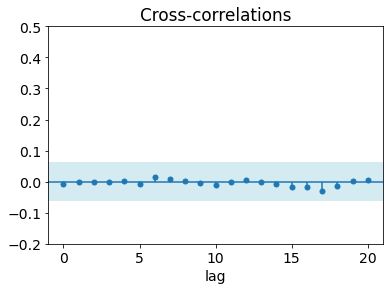

In [16]:
# CCF b/w residuals and input sequence
ccf_vals = ccf(residuals, u, adjusted=False) # ccf for lag >= 0
ccf_vals = ccf_vals[:21] # ccf for lag 0 to 20

# plot
lags = np.arange(0,21)

plt.figure(figsize=(6,4)), plt.vlines(lags, [0], ccf_vals), plt.axhline(0, 0, lags[-1])
plt.plot(lags, ccf_vals, marker='o', markersize=5, linestyle='None')
plt.gca().axhspan(-conf_int, conf_int, facecolor='lightblue', alpha=0.5) # shaded confidence interval
plt.xlabel('lag'), plt.title('Cross-correlations')
plt.ylim(-0.2, 0.5) 
plt.show()

In [17]:
#%% %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                         Transient response check
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [18]:
# generate step response of FIR model
step_response_FIR, _ = control.matlab.step(FIRmodel.G, T=30)
step_response_ARX, _ = control.matlab.step(ARXmodel.G, T=30)
step_response_ARMAX, _ = control.matlab.step(ARMAXmodel.G, T=30)

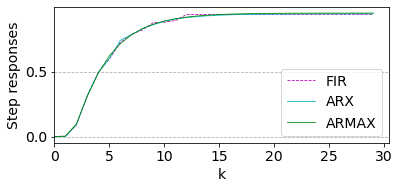

In [19]:
# overlay the step responses
plt.figure(figsize=(6,2.5))
plt.plot(step_response_FIR, 'm--', linewidth=0.8, label="FIR")
plt.plot(step_response_ARX, 'c', linewidth=0.8, label="ARX")
plt.plot(step_response_ARMAX, 'g', linewidth=0.8, label="ARMAX")
plt.ylabel('Step responses'), plt.xlabel('k'), plt.xlim(0), plt.legend()
plt.grid(which='both', axis='y', linestyle='--')
plt.show()